# Load Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import os
import re
import requests,io

from matplotlib.colors import LogNorm
import astropy.units as u
from astropy.table import Table
from scipy import interpolate
from shapely.geometry import LineString, Point
from astropy.stats import sigma_clipped_stats

from astropy.io import fits
from astropy.stats import sigma_clipped_stats,gaussian_sigma_to_fwhm, SigmaClip
from astropy.table import QTable
from astropy.utils.exceptions import AstropyDeprecationWarning


from photutils.background import LocalBackground, MMMBackground,Background2D,MedianBackground
from photutils.detection import DAOStarFinder
from photutils.psf import PSFPhotometry, IterativePSFPhotometry, IntegratedGaussianPRF,prepare_psf_model, IterativelySubtractedPSFPhotometry, DAOGroup, SourceGrouper

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Load the reduced data

In [2]:
data_path = 'reduced'

In [3]:
data = {}
data["M71B"] = np.load(f'{data_path}/M71B.npy')
data["M71V"] = np.load(f'{data_path}/M71G.npy')
data["M71R"] = np.load(f'{data_path}/M71R.npy')

In [4]:
for key, image in data.items():
    print(image.shape)

(1024, 1536)
(1024, 1536)
(1024, 1536)


In [5]:
error = {}
error["M71B"] = np.load(f'{data_path}/M71B_error.npy')
error["M71V"] = np.load(f'{data_path}/M71G_error.npy')[0]
error["M71R"] = np.load(f'{data_path}/M71R_error.npy')[0]

# Background Estimation


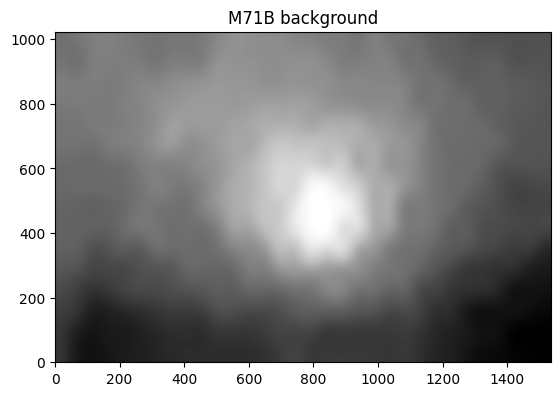

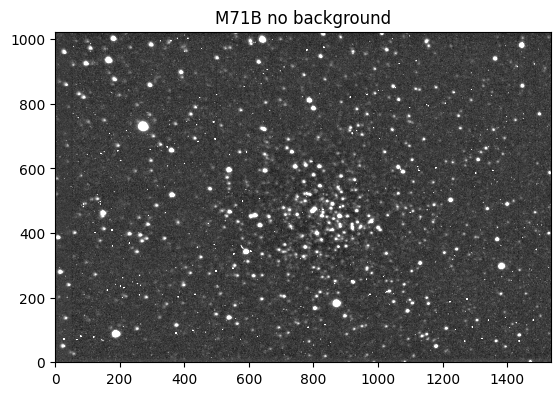

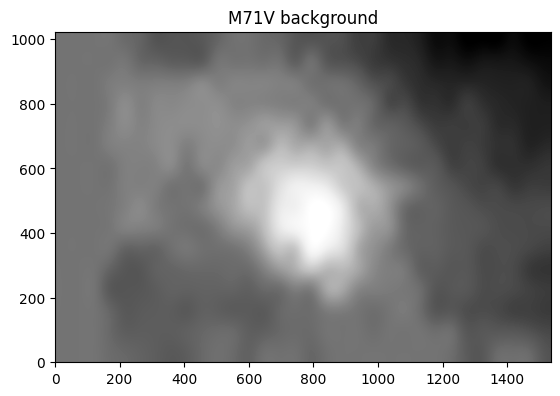

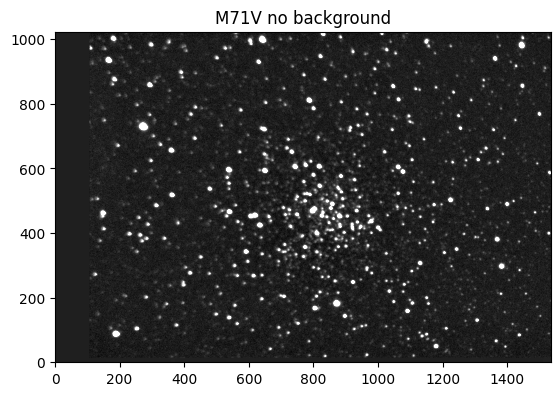

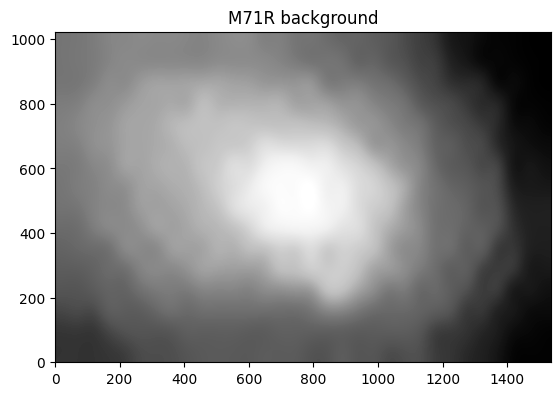

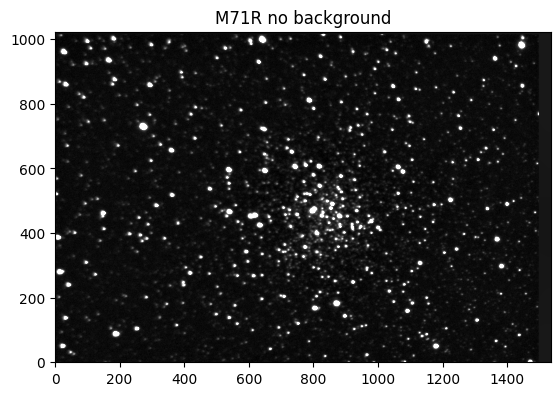

In [6]:
bkgs={}
bkg_uncs = {}
for key, image in data.items():
    sigma_clip = SigmaClip(sigma=3.0)
    bkg_estimator = MedianBackground()
    bkg = Background2D(image,
                       (64,48), #they say it works better if data is covered by int nb of boxes
                       filter_size=(3,3),sigma_clip=sigma_clip,
                    bkg_estimator=bkg_estimator)
    bkgs[key] = bkg.background
    bkg_uncs[key] = bkg.background_rms
    plt.title(f'{key} background')
    plt.imshow(bkg.background, origin='lower', cmap='Greys_r')
    plt.show()

    lo,up= np.percentile(image-bkg.background,1),np.percentile(image-bkg.background,99)
    plt.imshow(image-bkg.background, cmap='gray', origin='lower', clim=(lo,up))
    plt.title(f'{key} no background')
    plt.show()

    data[key] = image - bkg.background


# Get 2D FWHM

Found 389 stars in image M71B


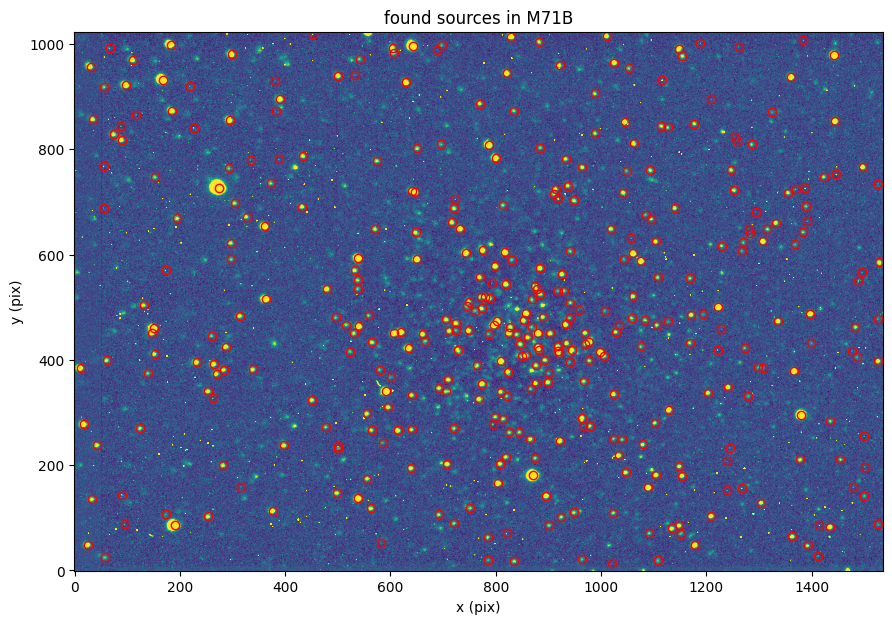

     x-FWHM 7.520484028167345+/-0.4995394297584866 (pix) for this M71B 
     y-FWHM 7.543236709391919+/-0.5430366832752382 (pix) for this M71B 
     FWHM 8.276898285950201+/-0.4304474080417869 (pix) for this M71B 
Found 692 stars in image M71V


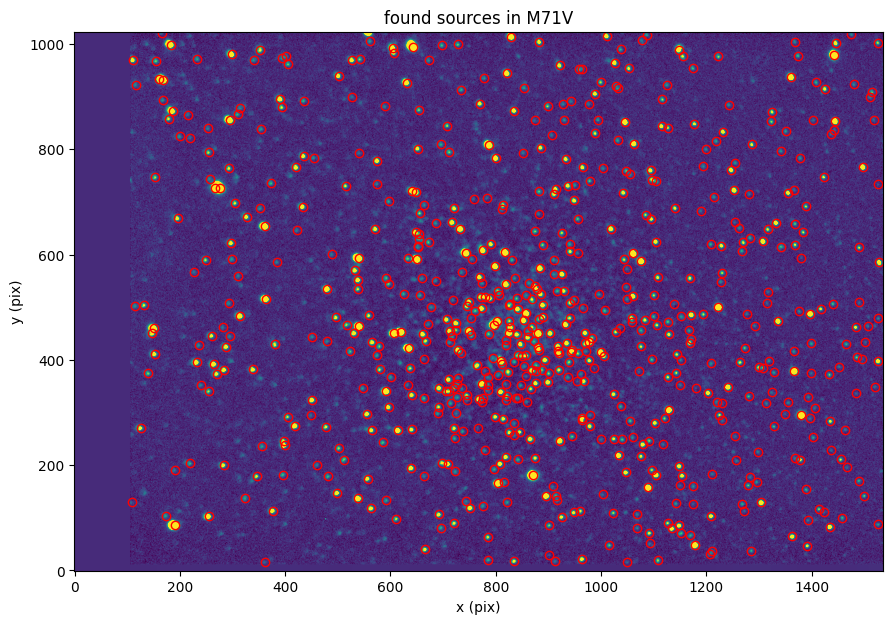

     x-FWHM 6.828366897753659+/-0.4662809462164129 (pix) for this M71V 
     y-FWHM 6.761200079012715+/-0.5070004636589255 (pix) for this M71V 
     FWHM 6.503584309731647+/-0.44311079383396124 (pix) for this M71V 
Found 1311 stars in image M71R


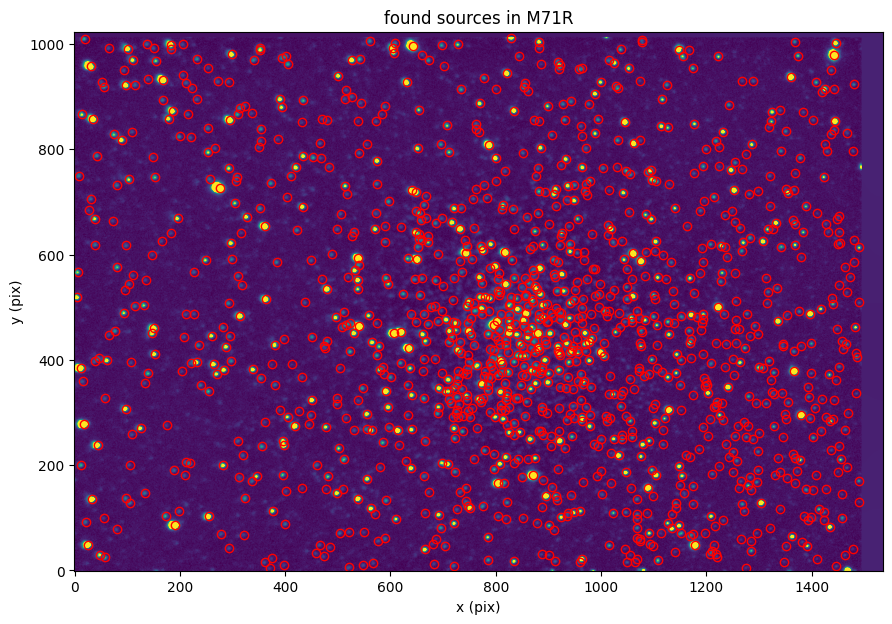

     x-FWHM 5.932190400447131+/-0.30015430029116796 (pix) for this M71R 
     y-FWHM 5.391102877704517+/-0.4496376143276076 (pix) for this M71R 
     FWHM 5.61788718724157+/-0.35558556100053657 (pix) for this M71R 


In [8]:
xfwhms = {}
yfwhms = {}
fwhms = {}
for key, image in data.items():
    mean, median, std = sigma_clipped_stats(image,sigma=3.0,maxiters=50)
    ## Find stars
    daofind = DAOStarFinder(fwhm=5.5, threshold=6.0*std, exclude_border= True)
    sources = daofind(image - median)
    print(f"Found {len(sources)} stars in image {key}")

    #Plot stars found
    fig = plt.figure(figsize=(12,7))
    l1 = np.percentile(image[np.isfinite(image)].flatten(), 1)
    l2 = np.percentile(image[np.isfinite(image)].flatten(), 99)
    plt.imshow(image,clim=(l1,l2),origin='lower')
    plt.plot(sources["xcentroid"],sources["ycentroid"],'or',mfc='none')
    plt.title(f"found sources in {key}")
    plt.xlabel("x (pix)")
    plt.ylabel("y (pix)")
    plt.show()

    ## Take nbright brightest stars 
    nbright = 5
    brightest = np.argsort(sources['flux'])[::-1][0:nbright]
    brsources = sources[brightest]

    ##########
    #get fwhm
    rmax = 25
    (ny,nx) = np.shape(image)
    from astropy.modeling import models,fitting
    fit_g = fitting.LevMarLSQFitter()
    allxfwhm, allyfwhm = np.zeros(len(brsources)),np.zeros(len(brsources))
    allfwhm,alltheta = np.zeros(len(brsources)),np.zeros(len(brsources))
    for i,src in enumerate(brsources):
        if int(src['ycentroid']) > rmax and int(src['ycentroid']) < ny-rmax and \
            int(src['xcentroid']) > rmax and int(src['xcentroid']) < nx-rmax:
            img = image[int(src['ycentroid'])-rmax:int(src['ycentroid'])+rmax,
                        int(src['xcentroid'])-rmax:int(src['xcentroid'])+rmax]
            subx,suby = np.indices(img.shape) # instead of meshgrid
            p_init = models.Gaussian2D(amplitude=np.max(img),x_mean=rmax,y_mean=rmax,x_stddev=1.0,y_stddev=1.0)
            fitgauss = fit_g(p_init, subx, suby, img - np.min(img))
            allxfwhm[i] = np.abs(fitgauss.x_stddev.value)
            allyfwhm[i] = np.abs(fitgauss.y_stddev.value)
            allfwhm[i] = 0.5*(allxfwhm[i]+allyfwhm[i])
            alltheta[i] = fitgauss.theta.value
    xfwhm,yfwhm = np.median(allxfwhm)*gaussian_sigma_to_fwhm,np.median(allyfwhm)*gaussian_sigma_to_fwhm
    fwhm = np.median(allfwhm)*gaussian_sigma_to_fwhm
    sigfwhm, sigxfwhm, sigyfwhm = np.std(allfwhm), np.std(allxfwhm), np.std(allyfwhm)
    medtheta = np.median(alltheta)
    print(f"     x-FWHM {xfwhm}+/-{sigxfwhm} (pix) for this {key} ")
    print(f"     y-FWHM {yfwhm}+/-{sigyfwhm} (pix) for this {key} ")
    print(f"     FWHM {fwhm}+/-{sigfwhm} (pix) for this {key} ")

    fwhms[key] = fwhm
    xfwhms[key] = xfwhm
    yfwhms[key] = yfwhm


# 2d gaussians

In [9]:
twodgauss = {}
psf_models = {}
for key, image in data.items():
    twodgauss[key] =  models.Gaussian2D(x_stddev=xfwhms[key]/gaussian_sigma_to_fwhm,
                                        y_stddev=yfwhms[key]/gaussian_sigma_to_fwhm,
                                        )
    
    #twodgauss[key].xname = 'x'
    #twodgauss[key].yname = 'y'
    #twodgauss[key].fluxname = 'amplitude'

    psf_models[key] = prepare_psf_model(twodgauss[key],xname='x_mean',yname='y_mean',fluxname='amplitude')


    

# Find point sources more accuretly with FWHM
more stars found this way:)

In [10]:
fwhms

{'M71B': 8.276898285950201,
 'M71V': 6.503584309731647,
 'M71R': 5.61788718724157}

In [12]:
for key in data.items():
    print(key[0])

M71B
M71V
M71R


Found 549 stars in image M71B


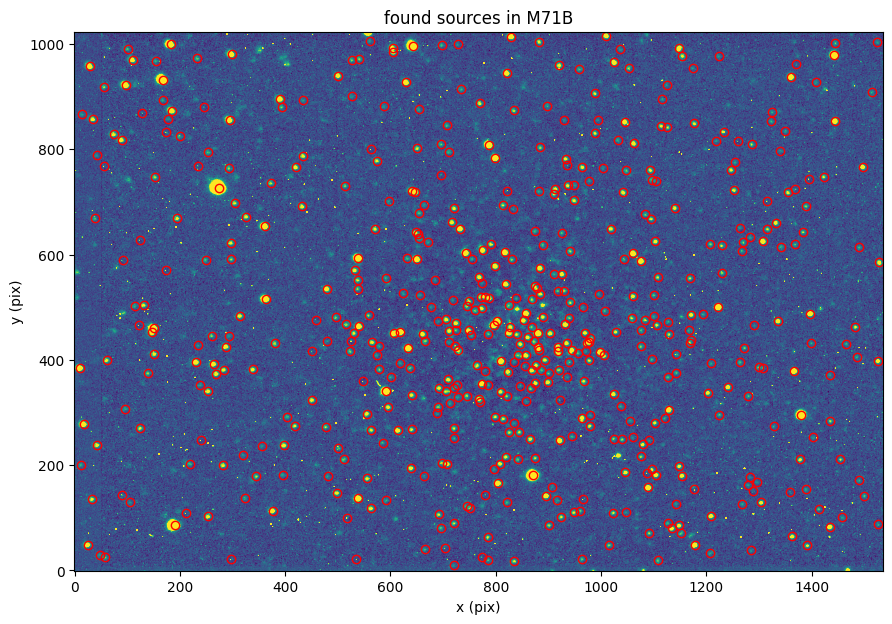

Found 889 stars in image M71V


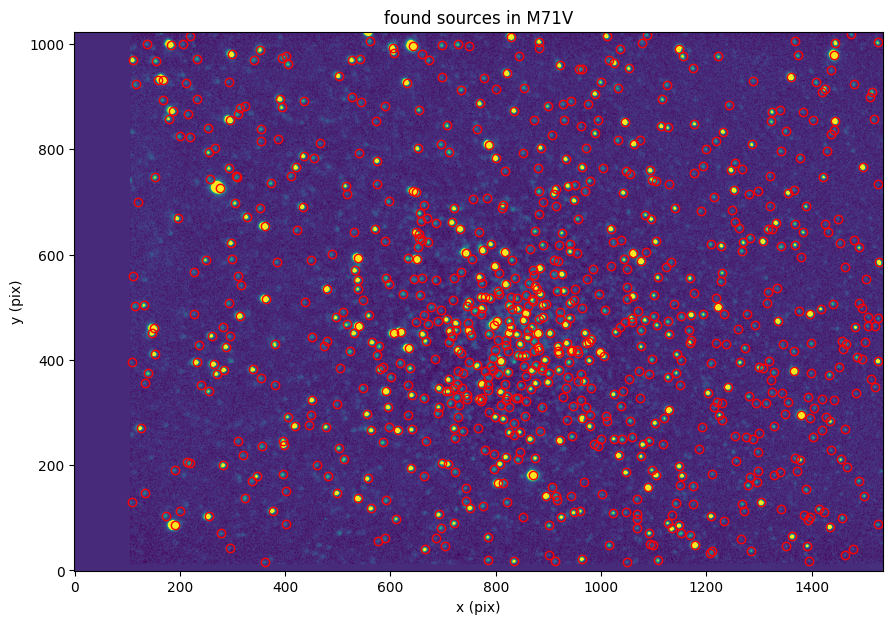

Found 739 stars in image M71R


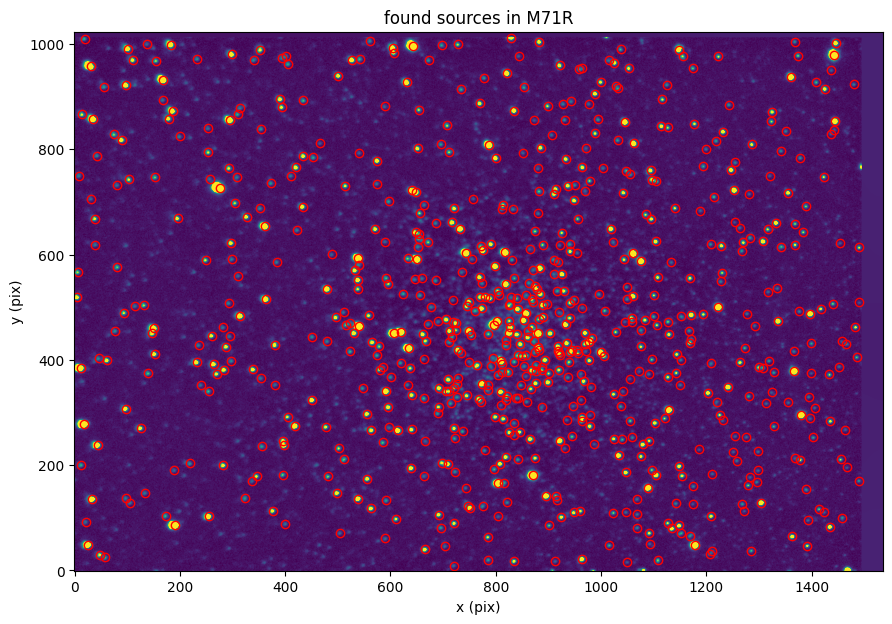

In [18]:
x_inits = {}
y_inits = {}

daofinds = {}

for key, image in data.items():

    mean, median, std = sigma_clipped_stats(image,sigma=3.0,maxiters=50)
    ## Find stars
    if key == 'M71R' :
        daofind = DAOStarFinder(fwhm=fwhms[key], threshold=12.0*std, exclude_border= True)
    else:
        daofind = DAOStarFinder(fwhm=fwhms[key], threshold=6.0*std, exclude_border= True)

    sources = daofind(image - median)
    print(f"Found {len(sources)} stars in image {key}")

    daofinds[key]=daofind

    #Plot stars found
    fig = plt.figure(figsize=(12,7))
    l1 = np.percentile(image[np.isfinite(image)].flatten(), 1)
    l2 = np.percentile(image[np.isfinite(image)].flatten(), 99)
    plt.imshow(image,clim=(l1,l2),origin='lower')
    plt.plot(sources["xcentroid"],sources["ycentroid"],'or',mfc='none')
    plt.title(f"found sources in {key}")
    plt.xlabel("x (pix)")
    plt.ylabel("y (pix)")
    plt.show()

    ## Take nbright brightest stars and save
    nbright = 5
    brightest = np.argsort(sources['flux'])[::-1]#[0:nbright]
    brsources = sources[brightest]

    x_inits[key] = brsources['xcentroid']
    y_inits[key] = brsources['ycentroid']



# Iterative PSF Photometry :)

In [19]:
phots = {}

for key, image in data.items():

    group = SourceGrouper(fwhms[key])
    PSF = PSFPhotometry(
        grouper=group ,     
        psf_model=IntegratedGaussianPRF(sigma=fwhms[key]/gaussian_sigma_to_fwhm),
        finder=daofinds[key],
        fit_shape=(3,3), #play with this, this may be small
        aperture_radius=5 ,#play with this as well
        fitter_maxiters=500
    )
    init_params = QTable()
    init_params['x'] = x_inits[key]
    init_params['y'] = y_inits[key]

    phots[key] = PSF(image, 
                        init_params = init_params,
                        error=np.sqrt(np.square(bkg_uncs[key])+np.square(error[key])), 
                )

In [20]:
phots['M71B']

<QTable length=549>
  id  group_id local_bkg ...           cfit          flags
int64  int64    float64  ...         float64         int64
----- -------- --------- ... ----------------------- -----
    1        1       0.0 ...  1.0490057036991978e-07     0
    2        2       0.0 ...   7.755021996835708e-07     0
    3        3       0.0 ...  1.8834536406169786e-06     0
    4        4       0.0 ...   4.970907248570871e-07     0
    5        5       0.0 ...  1.8868389311082787e-06     0
    6        6       0.0 ...    3.49384626031393e-06     0
    7        7       0.0 ...   7.093784537372285e-07     0
    8        8       0.0 ...    5.48951761762767e-06     0
    9        9       0.0 ...  1.4225389296091086e-05     0
   10       10       0.0 ...   3.173400322653104e-06     0
  ...      ...       ... ...                     ...   ...
  540      528       0.0 ...   0.0023601491734552894     0
  541      529       0.0 ...   0.0009733671490361225     0
  542      530       0.0 ...   5.364988328486483e-05     0
  543      531       0.0 ...  0.00019584561125749898     0
  544      532       0.0 ... -0.00020542922236581416     0
  545      533       0.0 ...   0.0005101073022587784     0
  546      534       0.0 ...    5.94860023825453e-05     0
  547      535       0.0 ...   0.0001915274293146789     0
  548      536       0.0 ... -0.00015362249284350737     0
  549      537       0.0 ...   4.604616481410189e-07     0

## See found stars 

<Figure size 640x480 with 0 Axes>

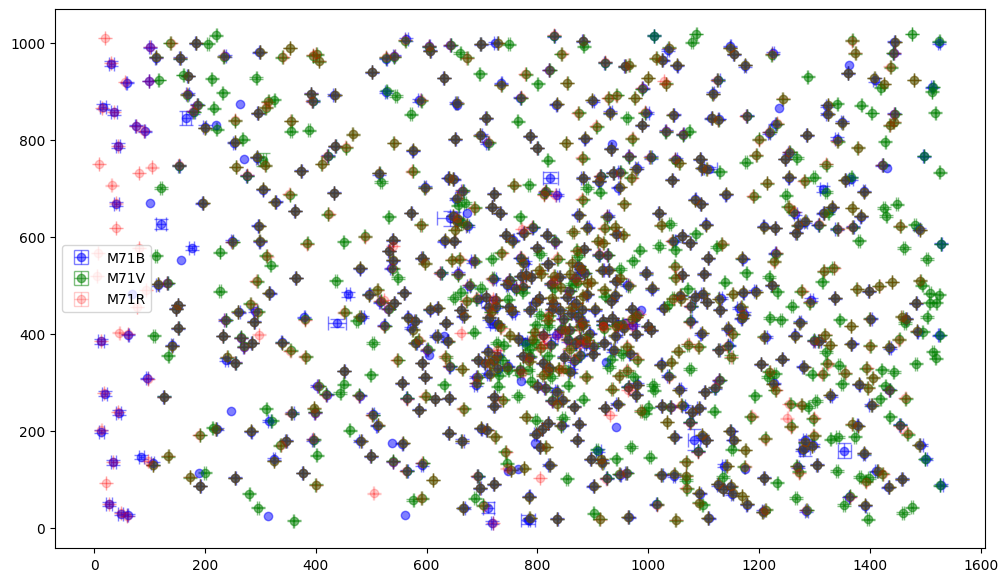

In [23]:

plt.clf()
fig = plt.figure(figsize=(12,7))
#plt.scatter(phots['M71B']['x_fit'],phots['M71B']['y_fit'], marker='o', c='blue', alpha=0.5)
#plt.scatter(phots['M71V']['x_fit'],phots['M71V']['y_fit'], marker='o', c='green',alpha=0.5)

plt.errorbar(x=phots['M71B']['x_fit'],y=phots['M71B']['y_fit'],
             xerr=phots['M71B']['x_err'],
             yerr=phots['M71B']['y_err'],fmt='o', ecolor='blue', elinewidth=1, capsize=5,c='blue',label="M71B",alpha=0.5
              )
plt.errorbar(x=phots['M71V']['x_fit'],y=phots['M71V']['y_fit'],
             xerr=phots['M71V']['x_err'],
             yerr=phots['M71V']['y_err'],fmt='o', ecolor='green', elinewidth=1, capsize=5,c='green',label="M71V",alpha=0.5
              )

plt.errorbar(x=phots['M71R']['x_fit'],y=phots['M71R']['y_fit'],
             xerr=phots['M71R']['x_err'],
             yerr=phots['M71R']['y_err'],fmt='o', ecolor='red', elinewidth=1, capsize=5,c='red',label="M71R",alpha=0.2
              )

plt.legend()

plt.show()

## Create dataframe for both Filters

In [24]:
m71b = phots['M71B'].to_pandas()
m71v = phots['M71V'].to_pandas()
m71r = phots['M71R'].to_pandas()


In [25]:
# function to filter out some bad points

def clean_df(data, n=0):
    # Drop rows with missing values
    df = data.dropna(inplace=False)

    # Apply the initial filtering conditions
    cond = (df['flags'] == 0) & (df['x_fit'] > 0) & (df['x_fit'] < 1536) & (df['y_fit'] > 0) & (df['y_fit'] < 1024)
    filtered_df = df[cond].copy()

    # Keep only nth lines with the highest 'flux_fit'
    if n > 0:
        filtered_df = filtered_df.nlargest(n, 'flux_fit')

    return filtered_df

In [26]:
print(f"B : {m71b.shape}")
print(f"V : {m71v.shape}")
print(f"V : {m71r.shape}")

B : (549, 17)
V : (889, 17)
V : (739, 17)


In [27]:
m71b = clean_df(m71b)
m71v = clean_df(m71v)
m71r = clean_df(m71r)

In [28]:
print(f"B : {m71b.shape}")
print(f"V : {m71v.shape}")
print(f"V : {m71r.shape}")

B : (517, 17)
V : (889, 17)
V : (736, 17)


In [68]:
matched_indexes_b = []
matched_indexes_v = []
matched_indexes_r = []

margin = 1 #3 pixeis

dfs_to_concat = []

m71 = pd.DataFrame(columns = ["Bflux", "Vflux","Rflux","Bflux_inc",'Vflux_inc', 'Rflux_inc', "Bx", "Bx_err", "By", "By_err", "Vx", "Vx_err", "Vy", "Vy_err","Rx", "Rx_err", "Ry", "Ry_err" ])
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    for i_m71v, row_m71v in m71v.iterrows():
        for i_m71b, row_m71b in m71b.iterrows():
            if abs(row_m71v['x_fit'] - row_m71b['x_fit']) < margin and abs(row_m71b['y_fit'] - row_m71v['y_fit']) < margin:
                for i_m71r, row_m71r in m71r.iterrows():
                    if abs(row_m71r['x_fit'] - row_m71b['x_fit']) < margin and abs(row_m71b['y_fit'] - row_m71r['y_fit']) < margin:
                        df_to_append = pd.DataFrame({
                        'Bflux': [row_m71b['flux_fit']],
                        'Vflux': [row_m71v['flux_fit']],
                        'Rflux': [row_m71r['flux_fit']],
                        'Bflux_inc': [row_m71b['flux_err']],
                        'Vflux_inc': [row_m71v['flux_err']],
                        'Rflux_inc': [row_m71r['flux_err']],
                        'Bx': [row_m71b['x_fit']],
                        'Bx_err': [row_m71b['x_err']],
                        'By': [row_m71b['y_fit']],
                        'By_err': [row_m71b['y_err']],
                        'Vx': [row_m71v['x_fit']],
                        'Vx_err': [row_m71v['x_err']],
                        'Vy': [row_m71v['y_fit']],
                        'Vy_err': [row_m71v['y_err']],
                        'Rx': [row_m71r['x_fit']],
                        'Rx_err': [row_m71r['x_err']],
                        'Ry': [row_m71r['y_fit']],
                        'Ry_err': [row_m71r['y_err']],
                
            })
                dfs_to_concat.append(df_to_append)

                if (i_m71v in matched_indexes_v) or (i_m71b in matched_indexes_b):
                    print(f"Something's wrong {i_m71v} {i_m71b}")
                matched_indexes_b.append(i_m71b)
                matched_indexes_v.append(i_m71v)

m71 = pd.concat(dfs_to_concat, ignore_index=True)

#m71b['flux_fit']
print(m71["Bflux"])

Series([], Name: Bflux, dtype: object)


0      683483.161531
1      352338.785864
2       66442.637608
3      110107.057379
4      206150.950292
           ...      
221      1330.327950
222      1737.872056
223      1548.947822
224      1884.261572
225      1238.268626
Name: Bflux, Length: 226, dtype: float64


In [62]:
matched_indexes_b = []
matched_indexes_v = []

margin = 1 #3 pixeis

dfs_to_concat = []

m71 = pd.DataFrame(columns = ["Bflux", "Vflux","Rflux","Bflux_inc",'Vflux_inc', 'Rflux_inc', "Bx", "Bx_err", "By", "By_err", "Vx", "Vx_err", "Vy", "Vy_err","Rx", "Rx_err", "Ry", "Ry_err" ])
with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    for i_m71v, row_m71v in m71v.iterrows():
        for i_m71b, row_m71b in m71b.iterrows():
            if abs(row_m71v['x_fit'] - row_m71b['x_fit']) < margin and abs(row_m71b['y_fit'] - row_m71v['y_fit']) < margin:
                df_to_append = pd.DataFrame({
                'Bflux': [row_m71b['flux_fit']],
                #'Vflux': [row_m71v['flux_fit']],
                'Bflux_inc': [row_m71b['flux_err']],
                #'Vflux_inc': [row_m71v['flux_err']],
                'Bx': [row_m71b['x_fit']],
                'Bx_err': [row_m71b['x_err']],
                'By': [row_m71b['y_fit']],
                'By_err': [row_m71b['y_err']],
                #'Vx': [row_m71v['x_fit']],
                #'Vx_err': [row_m71v['x_err']],
                #'Vy': [row_m71v['y_fit']],
                #'Vy_err': [row_m71v['y_err']],
                

            })
                #dfs_to_concat.append(df_to_append)

                if (i_m71v in matched_indexes_v) or (i_m71b in matched_indexes_b):
                    print(f"Something's wrong {i_m71v} {i_m71b}")
                matched_indexes_b.append(i_m71b)
                matched_indexes_v.append(i_m71v)

#m71 = pd.concat(dfs_to_concat, ignore_index=True)

#m71b['flux_fit']
print(m71["Bflux"])


Series([], Name: Bflux, dtype: object)


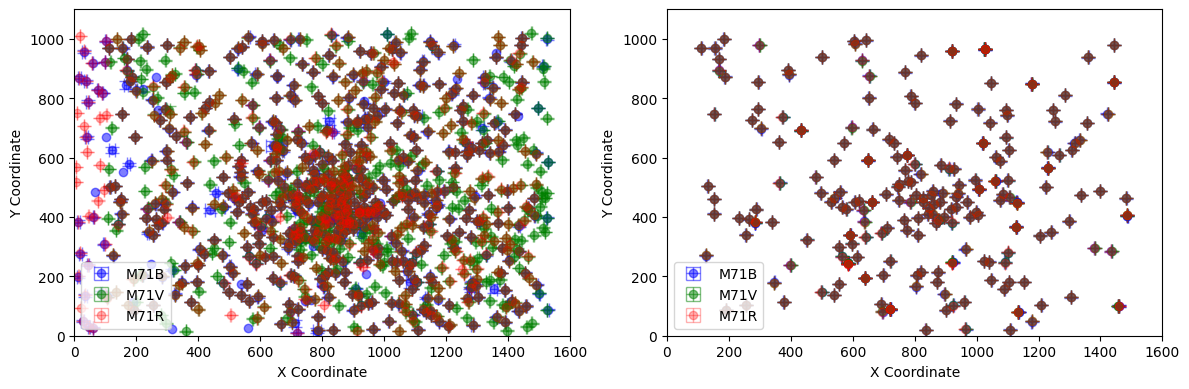

In [71]:
#SEE THE DIFFERENCE OF CORRESPOND STARS

plt.figure(figsize=(12, 4))  

plt.subplot(1, 2, 1) 
plt.errorbar(x=phots['M71B']['x_fit'],y=phots['M71B']['y_fit'],
             xerr=phots['M71B']['x_err'],
             yerr=phots['M71B']['y_err'],fmt='o', elinewidth=1, capsize=5,c='blue',label="M71B",alpha=0.5
              )
plt.errorbar(x=phots['M71V']['x_fit'],y=phots['M71V']['y_fit'],
             xerr=phots['M71V']['x_err'],
             yerr=phots['M71V']['y_err'],fmt='o', elinewidth=1, capsize=5,c='green',label="M71V",alpha=0.5
              )

plt.errorbar(x=phots['M71R']['x_fit'],y=phots['M71R']['y_fit'],
             xerr=phots['M71R']['x_err'],
             yerr=phots['M71R']['y_err'],fmt='o', elinewidth=1, capsize=5,c='red',label="M71R",alpha=0.3
              )

plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.xlim(0, 1600)  
plt.ylim(0, 1100) 
plt.legend()

plt.subplot(1, 2, 2) 

plt.errorbar(x=m71["Bx"],y=m71["By"],
             xerr=m71["Bx_err"],
             yerr=m71["By_err"],fmt='o', elinewidth=1, capsize=5,c='blue',label="M71B",alpha=0.5
              )

plt.errorbar(x=m71["Vx"],y=m71["Vy"],
             xerr=m71["Vx_err"],
             yerr=m71["Vy_err"],fmt='o', elinewidth=1, capsize=5,c='green',label="M71V",alpha=0.5
              )

plt.errorbar(x=m71["Rx"],y=m71["Ry"],
             xerr=m71["Rx_err"],
             yerr=m71["Ry_err"],fmt='o', elinewidth=1, capsize=5,c='red',label="M71R",alpha=0.3
              )


plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.xlim(0, 1600)  
plt.ylim(0, 1100) 
plt.legend()


plt.tight_layout()
plt.show()


In [73]:
def calc_m (flux):
    return -2.5 * np.log10(flux)

def calc_m_err(flux, flux_err):
    return abs(-2.5/(flux*np.log(10))*flux_err)

def calc_M (m,d):
    return m - 5*np.log10(d) + 5

def calc_M_err (m_err, d , d_err):
    return np.sqrt(m_err **2 + ((-5/(d *np.log(10)))*d_err)**2 )
    

In [110]:
m71_Bflux = m71["Bflux"]/90
m71_Vflux = m71["Vflux"]/60
m71_Rflux = m71["Rflux"]/60

m71_Bflux_inc =m71["Bflux_inc"]/90
m71_Vflux_inc =m71["Vflux_inc"]/60
m71_Rflux_inc =m71["Rflux_inc"]/60


#Standard star hip100108
#https://simbad.cds.unistra.fr/simbad/sim-ref?bibcode=2020yCat.1350....0G
d_StStar = 159.872
d_StStar_err = 1.7866
M_abs_StStar_B_true = 5.703
M_abs_StStar_V_true = 5.592933

StStar_Bflux = 407909.84171543794
StStar_Bflux_err= 206854.64573340997

StStar_Vflux = 694915.3502797772
StStar_Vflux_err = 16036.587527501777

StStar_Rflux = 881181.1589937279
StStar_Rflux_err = 18761.352281041938

m_StStar_B = calc_m(StStar_Bflux) #+instrumental zero point
m_StStar_B_err = calc_m_err(flux=StStar_Bflux, flux_err=StStar_Bflux_err)

m_StStar_V = calc_m(StStar_Vflux) #+instrumental zero point
m_StStar_V_err = calc_m_err(flux=StStar_Vflux, flux_err=StStar_Vflux_err)

m_StStar_R =calc_m(StStar_Rflux)  #+instrumental zero point
m_StStar_R_err = calc_m_err(flux=StStar_Rflux, flux_err=StStar_Rflux_err)

print(f"Standard Star mB = {m_StStar_B} +- {m_StStar_B_err}")
print(f"Standard Star mV = {m_StStar_V} +- {m_StStar_V_err}")
print(f"Standard Star mR = {m_StStar_R} +- {m_StStar_R_err}")

M_abs_StStar_B = calc_M(m=m_StStar_B,d=d_StStar)
M_abs_StStar_B_err = calc_M_err(m_err=m_StStar_B_err,d=d_StStar,d_err=d_StStar_err)

M_abs_StStar_V = calc_M(m=m_StStar_V,d=d_StStar)
M_abs_StStar_V_err = calc_M_err(m_err=m_StStar_V_err,d=d_StStar,d_err=d_StStar_err)

M_abs_StStar_R = calc_M(m=m_StStar_R,d=d_StStar)
M_abs_StStar_R_err = calc_M_err(m_err=m_StStar_R_err,d=d_StStar,d_err=d_StStar_err)

print(f"Standard Star MB = {M_abs_StStar_B} +- {M_abs_StStar_B_err}")
print(f"Standard Star MV = {M_abs_StStar_V} +- {M_abs_StStar_V_err}")
print(f"Standard Star MR = {M_abs_StStar_R} +- {M_abs_StStar_R_err}")

inst_calib_B = M_abs_StStar_B_true - M_abs_StStar_B
inst_calib_V = M_abs_StStar_V_true - M_abs_StStar_V
#inst_calib_R = M_abs_StStar_R_true - M_abs_StStar_R

inst_calib_B_err = M_abs_StStar_B_err
inst_calib_V_err = M_abs_StStar_V_err
#inst_calib_R_err = M_abs_StStar_R_err

m71["mB"] = calc_m(flux=m71["Bflux"])
m71["mB_err"] = calc_m_err(flux=m71["Bflux"],flux_err=m71["Bflux_inc"])

m71["mV"] = calc_m(flux=m71["Vflux"])
m71["mV_err"] = calc_m_err(flux=m71["Vflux"],flux_err=m71["Vflux_inc"])

m71["mR"] = calc_m(flux=m71["Rflux"])
m71["mR_err"] = calc_m_err(flux=m71["Rflux"],flux_err=m71["Rflux_inc"])

d= 3800
d_err=100

MB_uncalib = calc_M(m=m71["mB"],d=d)
MB_uncalib_err = calc_M_err(m_err=m71["mB_err"],d=d,d_err=d_err)

MV_uncalib = calc_M(m=m71["mV"],d=d)
MV_uncalib_err = calc_M_err(m_err=m71["mV_err"],d=d,d_err=d_err)

MR_uncalib = calc_M(m=m71["mR"],d=d)
MR_uncalib_err = calc_M_err(m_err=m71["mR_err"],d=d,d_err=d_err)

m71["MB"] = inst_calib_B + MB_uncalib
m71["MB_err"] = np.sqrt( inst_calib_B_err**2 + MB_uncalib_err**2 )

m71["MV"] = inst_calib_V + MV_uncalib
m71["MV_err"] = np.sqrt( inst_calib_V_err**2 + MV_uncalib_err**2 )

#m71["MR"] = inst_calib_R + MR_uncalib
#m71["MR_err"] = np.sqrt( inst_calib_R_err**2 + MR_uncalib_err**2 )


Standard Star mB = -14.026410459364964 +- 0.550586318414587
Standard Star mV = -14.604829762750837 +- 0.0250555750025832
Standard Star mR = -14.862663006737751 +- 0.023116562597650523
Standard Star MB = -20.045272499474983 +- 0.5511208240759448
Standard Star MV = -20.623691802860858 +- 0.03488051810867338
Standard Star MR = -20.88152504684777 +- 0.033514835090605995


In [77]:
#Read the models
#Important: Open the model file (in any text editor) and remove the # at the beginning of the line 13 (names of the columns)
#Otherwise python won't know the column names and will call them col1, col2 etc.
isochrones = Table.read('output993364478302.dat', format='ascii')
print(isochrones.columns)

#Let's see which ages we have in the model file
logages=np.unique(isochrones['logAge']) #find the unique age entries
ages=np.unique(10**isochrones['logAge']/1e6) #in Myrs
for logage, age in zip(logages,ages): print(logage,age) #print all of that

<TableColumns names=('Zini','MH','logAge','Mini','int_IMF','Mass','logL','logTe','logg','label','McoreTP','C_O','period0','period1','pmode','Mloss','tau1m','X','Y','Xc','Xn','Xo','Cexcess','Z','mbolmag','Umag','Bmag','Vmag','Rmag','Imag','Jmag','Hmag','Kmag')>
7.0 10.0
7.09691 12.499999625598054
7.17609 14.999956513820402
7.24304 17.50007862882901
7.30103 20.000000199681043
7.35218 22.499869541650266
7.39794 24.9999995007974
7.43933 27.499829424260362
7.47712 29.999913327161497
7.51188 32.49974848542795
7.54407 35.00015760710141
7.57403 37.4998905357492
7.60206 40.00000079872417
7.62839 42.50010470526256
7.65321 44.99973953258027
7.67669 47.499605206891204
7.69897 49.9999995007974
7.72016 52.50008420833815
7.74036 54.99965939764019
7.75967 57.500285360875914
7.77815 59.999827253364394
7.79588 62.49999750398704
7.81291 64.99949761981426
7.8293 67.4994136121949
7.8451 70.00031591308975
7.86034 72.50033277865747
7.87506 74.99978182030029
7.8893 77.49969618775764
7.90309 80.00000239617252


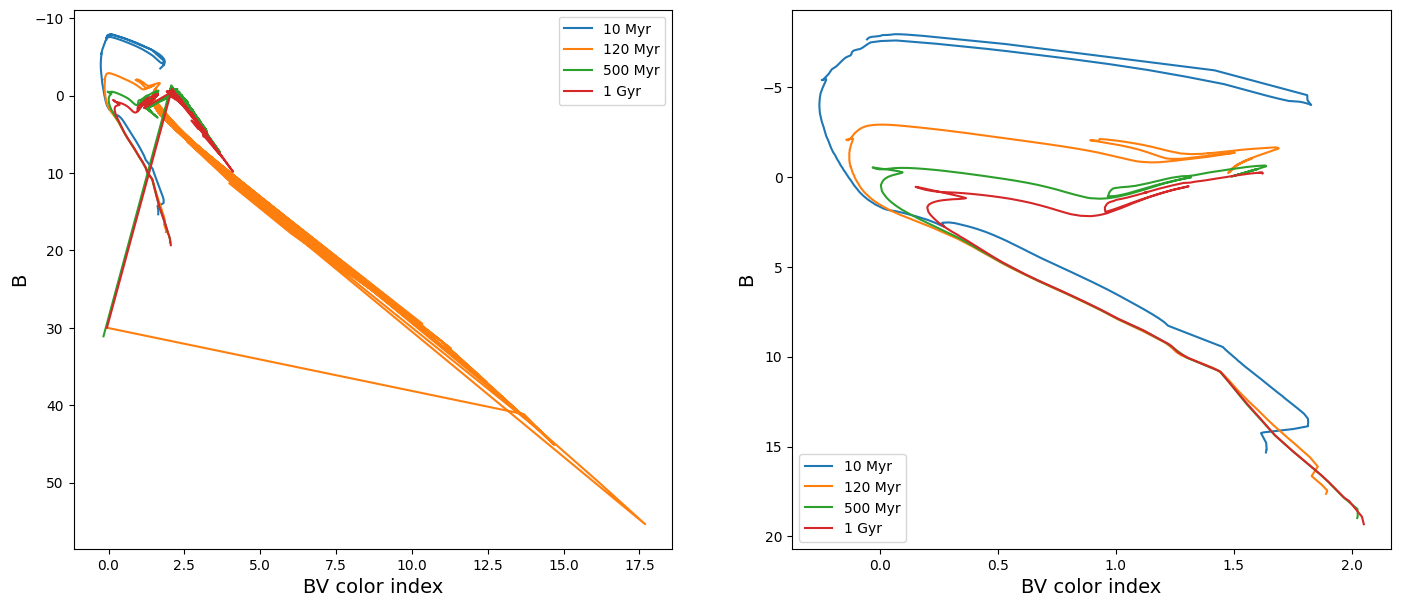

In [78]:
#you can select the isochrone with some particular age
age_1 = isochrones['logAge'] == 7 # 10 Myrs; False where not this age, True where yes
age_2 = isochrones['logAge'] == 8.07918 # 120 Myrs
age_3 = isochrones['logAge'] == 8.69897 # 500 Myrs
age_4 = isochrones['logAge'] == 9 # 1 Gyrs

fig,[ax1,ax2] = plt.subplots(nrows=1,ncols=2,figsize=(17,7))
ax1.plot(isochrones['Bmag'][age_1] - isochrones['Vmag'][age_1], isochrones['Bmag'][age_1],label='10 Myr')
ax1.plot(isochrones['Bmag'][age_2] - isochrones['Vmag'][age_2], isochrones['Bmag'][age_2],label='120 Myr')
ax1.plot(isochrones['Bmag'][age_3] - isochrones['Vmag'][age_3], isochrones['Bmag'][age_3],label='500 Myr')
ax1.plot(isochrones['Bmag'][age_4] - isochrones['Vmag'][age_4], isochrones['Bmag'][age_4],label='1 Gyr')
ax1.invert_yaxis()
ax1.set_xlabel('BV color index',fontsize=14)
ax1.set_ylabel('B',fontsize=14)
ax1.legend()

#We can cut off the more evolved stages
N=250
ax2.plot(isochrones['Bmag'][age_1][0:N] - isochrones['Vmag'][age_1][0:N], isochrones['Bmag'][age_1][0:N],label='10 Myr')
ax2.plot(isochrones['Bmag'][age_2][0:N] - isochrones['Vmag'][age_2][0:N], isochrones['Bmag'][age_2][0:N],label='120 Myr')
ax2.plot(isochrones['Bmag'][age_3][0:N] - isochrones['Vmag'][age_3][0:N], isochrones['Bmag'][age_3][0:N],label='500 Myr')
ax2.plot(isochrones['Bmag'][age_4][0:N] - isochrones['Vmag'][age_4][0:N], isochrones['Bmag'][age_4][0:N],label='1 Gyr')
ax2.invert_yaxis()
ax2.set_xlabel('BV color index',fontsize=14)
ax2.set_ylabel('B',fontsize=14)
ax2.legend()

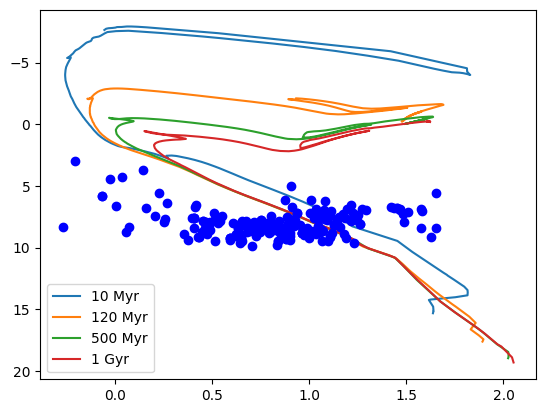

In [104]:
#Let's now plot a model on top of our data, just approximately
plt.errorbar(
    x=m71["mB"] - m71["mV"],
    y=m71["MB"],
    #xerr= np.sqrt( m71["mB_err"]**2 + m71["mV_err"]**2  ),
    #yerr=m71["MB_err"],
    fmt='o', ecolor='blue', elinewidth=1, capsize=5,c='blue'
)

#Important: isochrones are given in absolute magnitudes, while the data come in apparent
#median_parallax=np.nanmedian(data['parallax'])
#dist=1000/median_parallax #Important: This distance here is just for demonstration (approximate), we will use a different method o determine it
#DM=5*np.log10(dist)-5 #distance modulus
#print('distance modulus:',DM)
N=250
plt.plot(isochrones['Bmag'][age_1][0:N] - isochrones['Vmag'][age_1][0:N], isochrones['Bmag'][age_1][0:N],label='10 Myr')
plt.plot(isochrones['Bmag'][age_2][0:N] - isochrones['Vmag'][age_2][0:N], isochrones['Bmag'][age_2][0:N],label='120 Myr')
plt.plot(isochrones['Bmag'][age_3][0:N] - isochrones['Vmag'][age_3][0:N], isochrones['Bmag'][age_3][0:N],label='500 Myr')
plt.plot(isochrones['Bmag'][age_4][0:N] - isochrones['Vmag'][age_4][0:N], isochrones['Bmag'][age_4][0:N],label='1 Gyr')
plt.gca().invert_yaxis()
plt.legend()

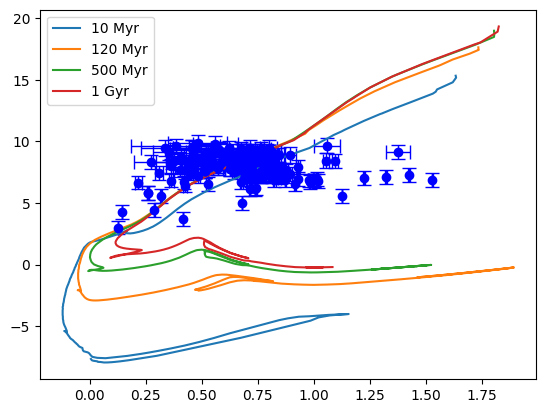

In [95]:
#Let's now plot a model on top of our data, just approximately
plt.errorbar(
    x=m71["mV"] - m71["mR"],
    y=m71["MB"],
    xerr= np.sqrt( m71["mR_err"]**2 + m71["mV_err"]**2  ),
    yerr=m71["MB_err"],
    fmt='o', ecolor='blue', elinewidth=1, capsize=5,c='blue'
)

#Important: isochrones are given in absolute magnitudes, while the data come in apparent
#median_parallax=np.nanmedian(data['parallax'])
#dist=1000/median_parallax #Important: This distance here is just for demonstration (approximate), we will use a different method o determine it
#DM=5*np.log10(dist)-5 #distance modulus
#print('distance modulus:',DM)
plt.plot(isochrones['Vmag'][age_1][0:N] - isochrones['Rmag'][age_1][0:N], isochrones['Bmag'][age_1][0:N],label='10 Myr')
plt.plot(isochrones['Vmag'][age_2][0:N] - isochrones['Rmag'][age_2][0:N], isochrones['Bmag'][age_2][0:N],label='120 Myr')
plt.plot(isochrones['Vmag'][age_3][0:N] - isochrones['Rmag'][age_3][0:N], isochrones['Bmag'][age_3][0:N],label='500 Myr')
plt.plot(isochrones['Vmag'][age_4][0:N] - isochrones['Rmag'][age_4][0:N], isochrones['Bmag'][age_4][0:N],label='1 Gyr')
plt.legend()

5.15250934232888 (0, 0)
*** Best fit model: age =  10.0 Myr; distance= 3000 pc


Text(0, 0.5, 'age in Myr')

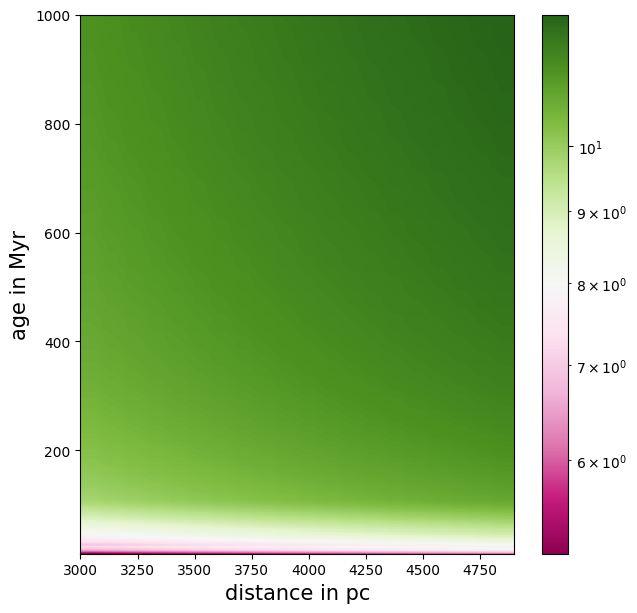

In [112]:
#all the ages that we will test
ages=np.unique(isochrones['logAge'])

#distance
dmin,dmax,step=3000,5000,100
distances = np.arange(dmin,dmax,step)

#define an array to save the root-mean-square deviation values
rmsd=np.zeros(shape=(len(ages),len(distances)))
for i in range(len(ages)):
    age=ages[i]
    for j in range(len(distances)):

        ## model
        distance=distances[j]
        DM=5*np.log10(distance)-5 #distance modulus
        isochrone=isochrones[isochrones['logAge'] == age][0:N]
        col_iso = isochrone['Bmag'] - isochrone['Vmag'] #color isochrone
        mag_iso = isochrone['Vmag'] + DM #magnitude isochrone, shifted to the distance of the cluster
        line = LineString(np.asarray([col_iso,mag_iso]).T) #Representation of the isochrone as a continuous line

        ## data
        d=np.empty(len(data))
        for k in range(len(data)):

            col_data=m71['mB'][k] - m71['mV'][k]

            mag_data=m71['MV'][k]

            point=Point(col_data,mag_data)
            
            d[k] = point.distance(line) #shortest distance of the point to the line of the isochrone
        rmsd[i,j]=np.sqrt(np.nanmean(d)**2)

fig,ax = plt.subplots(figsize=(7,7))
pos=ax.imshow(rmsd,cmap='PiYG', norm=LogNorm(),origin='lower',
               extent=[distances[0],distances[-1],10**ages[0]/1e6,10**ages[-1]/1e6],aspect='auto')
fig.colorbar(pos, ax=ax)#,format= "%d")

#Find the grid position of the minimum rmsd
minrmsd_pos=np.unravel_index(rmsd.argmin(), rmsd.shape)
print(np.nanmin(rmsd),minrmsd_pos)
print("*** Best fit model: age = ", np.round(10**ages[minrmsd_pos[0]]/1e6),'Myr; distance=',distances[minrmsd_pos[1]],'pc')
best_age=ages[minrmsd_pos[0]]
best_dist=distances[minrmsd_pos[1]]
plt.xlabel('distance in pc',fontsize=15)
plt.ylabel('age in Myr',fontsize=15)